https://www.kaggle.com/c/mlcourse-dota2-win-prediction/overview

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import time
from tqdm import tqdm_notebook
#from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, 
import statsmodels.api as sm
import warnings
#warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier


In [2]:
import ujson as json

In [3]:
n_fold = 5
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [4]:
PATH_TO_DATA = 'data/'

Training function

In [5]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    # placeholder for out-of-fold, i.e. validation scores
    oof = np.zeros(len(X)) 
    prediction = np.zeros(len(X_test))
    #for predictions
    scores = []
    # and for feature importance
    feature_importance = pd.DataFrame()
    
    #RUN THE LOOP OVER FOLDS
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index, valid_index)
        print(f"train len is: {len(train_index)};\nvalid len is: {len(valid_index)}")
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        #X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            
            #TRAIN THE MODEL
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 500)
            
            y_pred_valid = model.predict(X_valid)
            
            #CALCULATE PREDICTIONS FOR TEST DATA, using best_iteration on the fold
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=300, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. AUC: {score:.4f}.') #
            print('') #
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
        
        #CALCULATE PREDICTION FOR VALIDATION SET
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [6]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': 20,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'bagging_seed' : 42,
          'objective': 'binary'
         }

In [7]:
# https://www.kaggle.com/shokhan/lightgbm-starter-code - CELL 14
params2 = {
        'boost': 'gbdt',
    
        'bagging_freq': 5,  #handling overfitting
        'bagging_fraction': 0.5,  #handling overfitting - adding some noise
        'boost_from_average':'false',
        'feature_fraction': 0.05, #handling overfitting
        'learning_rate': 0.01,  #the changes between one auc and a better one gets really small thus a small learning rate performs better
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 10,
        'num_threads': 5,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }

### JSON_DATA
I'll use functions from this kernel: https://www.kaggle.com/kashnitsky/dota-2-win-prediction-random-forest-starter

In [8]:
with open(os.path.join('data/', 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

The match object is now a big Python dictionary. In **match['players']** we have a description of each player.

In [9]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [10]:
player = match['players'][1]
print(len(player['times']))

40


In [11]:
player.keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

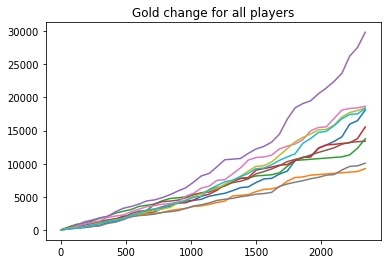

In [12]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
    
plt.title('Gold change for all players');

In [13]:
json_list = [] #store data that are read
number_of_rows = 50 #how many lines to read 

#reading data from .jsonl file
with open(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')) as fin:
    for i in range(number_of_rows):
        line = fin.readline()
        json_list.append(json.loads(line))
        
#how many matches to read. For example I took 1
for i in range(1, 2):
    for j in range(1, 2):#there is 5 players in each team. But I want to look on only one player.
        print(json.dumps(json_list[i]['players'][j], indent=4, sort_keys=True))

{
    "ability_upgrades":[
        {
            "ability":5514,
            "level":1,
            "time":232
        },
        {
            "ability":5515,
            "level":2,
            "time":304
        },
        {
            "ability":5515,
            "level":3,
            "time":322
        },
        {
            "ability":5514,
            "level":4,
            "time":391
        },
        {
            "ability":5515,
            "level":5,
            "time":499
        },
        {
            "ability":5517,
            "level":6,
            "time":581
        }
    ],
    "ability_uses":{
        "centaur_double_edge":11,
        "centaur_hoof_stomp":8,
        "centaur_stampede":2
    },
    "account_id_hash":"1c2500195e6ab646fc9371344724aa77",
    "actions":{
        "1":3679,
        "10":183,
        "11":8,
        "15":19,
        "16":18,
        "19":14,
        "2":2,
        "33":183,
        "4":810,
        "5":4,
        "6":42,
        "7":12,


}


In [14]:
for i in range(1, 5): #now we will look at 4 matches
    for j in range(1, 5):#and now will take 5 players
        print(json.dumps(list(map(lambda x: x['id'][5:],
                                  json_list[i]['players'][j]['hero_inventory'])),
                         indent=4, sort_keys=True))

[
    "stout_shield",
    "soul_ring",
    "tranquil_boots",
    "chainmail"
]
[
    "magic_wand",
    "dust",
    "boots",
    "ward_dispenser",
    "tpscroll"
]
[
    "magic_wand",
    "pers",
    "blight_stone",
    "tpscroll",
    "ring_of_aquila"
]
[
    "boots",
    "stout_shield",
    "tpscroll"
]
[
    "tango",
    "flask",
    "stout_shield",
    "clarity",
    "enchanted_mango",
    "tpscroll"
]
[
    "stout_shield",
    "blight_stone",
    "tpscroll"
]
[
    "stout_shield",
    "quelling_blade",
    "tango",
    "tpscroll"
]
[
    "tango",
    "faerie_fire",
    "tpscroll"
]
[
    "soul_ring",
    "stout_shield",
    "magic_wand",
    "boots",
    "faerie_fire",
    "tpscroll"
]
[
    "boots",
    "bottle",
    "null_talisman",
    "helm_of_iron_will",
    "null_talisman"
]
[
    "tranquil_boots",
    "magic_stick",
    "orb_of_venom",
    "ward_observer"
]
[
    "power_treads",
    "quelling_blade",
    "clarity",
    "ring_of_health",
    "tpscroll"
]
[
    "ring_of_basili

## players

#### Function to read files with game descriptions
The following function read_matches(filename), can be used to read raw data on Dota 2 games.

We recommend to install two Python packages: ujson and tqdm, it'll make the execution faster and

In [15]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    print(filename)
    total_matches = MATCHES_COUNT.get(filename)
    print(total_matches)
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

#### How to build initial features from scratch
Now we diclose the code that we used to build initial features train_features.csv and test_features.csv. You can modify the following code to add more features.

In a nutshell:

1. ***extract_features_csv(match)*** extracts features from game descriptions and writes them into a dictionary
2. ***extract_targets_csv(match, targets)*** extracts the target variable radiant_win
3. iterating through the file with raw data, we collect all features
4. with ***pandas.DataFrame.from_records()*** we create dataframes with new features

In [16]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    #('lobby_type', lambda m: m['lobby_type']), # ну уж вряд ли
    ('objectives_len', lambda m: len(m['objectives'])), # То же хз нужно ли
    #('chat_len', lambda m: len(m['chat'])),# ну уж вряд ли
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    #'x', #### координаты на карте? хех
    #'y', #### ?
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

#### Достаем признаки для обучения

In [17]:
def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))
        # добавляем айтемы https://www.kaggle.com/grazder/hero-items-guide
        row.append((f'{player_name}_items', list(map(lambda x: x['id'][5:], player['hero_inventory']))))
            
    return collections.OrderedDict(row)

#### Достаем признаки для ответа

In [18]:
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

### Составляем новые матрицы для обучения, теста и ответа

In [19]:
def create_features_from_jsonl(matches_file):
  
    df_new_features = []

    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        features = extract_features_csv(match)

        df_new_features.append(features)

    df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
    return df_new_features

#### ВСЕ СОХРАНЕНО И ДАННЫЕ УЖЕ НАХОДЯТСЯ В ОГУРЧИКАХ!!!!!!!!!!!!!!

```python
%%time
train_new_features = create_features_from_jsonl(os.path.join(PATH_TO_DATA, 'train_matches.jsonl'))
```

```python
test_new_features = create_features_from_jsonl(os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))
```

```python
%%time
PATH_TO_DATA = 'data/'
train_new_features = []
train_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    
    match_id_hash = match['match_id_hash']
    #features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    #train_new_features.append(features)
    train_new_targets.append(targets)
print(train_new_targets[:5])

train_new_targets = pd.DataFrame.from_records(train_new_targets).set_index('match_id_hash')
```

#### Сохраняем маринованные огурчики

```python
import pickle as pkl

#Better to save extracted data in files, because extracting takes time...
train_new_features.to_pickle('data/df_train.pkl')
train_new_targets.to_pickle('data/df_target.pkl')
test_new_features.to_pickle('data/df_test.pkl')
```

#### Айтемы ---

In [20]:
def add_items_dummies(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        players = [f'{team}{i}' for i in range(1, 6)]
        item_columns = [f'{player}_items' for player in players]

        d = pd.get_dummies(full_df[item_columns[0]].apply(pd.Series).stack()).sum(level=0, axis=0)
        dindexes = d.index.values

        for c in item_columns[1:]:
            d = d.add(pd.get_dummies(full_df[c].apply(pd.Series).stack()).sum(level=0, axis=0), fill_value=0)
            d = d.loc[dindexes]

        full_df = pd.concat([full_df, d.add_prefix(f'{team}_item_')], axis=1, sort=False)
        full_df.drop(columns=item_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df

In [21]:
def drop_consumble_items(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        consumble_columns = ['tango', 'tpscroll', 
                             'bottle', 'flask',
                            'enchanted_mango', 'clarity',
                            'faerie_fire', 'ward_observer',
                            'ward_sentry']
        
        starts_with = f'{team}_item_'
        consumble_columns = [starts_with + column for column in consumble_columns]
        full_df.drop(columns=consumble_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df

# ЗАГРУЖАЕМ ДАННЫЕ ИЗ ТРЕХЛИТРОВЫХ БАНОК

In [22]:
%%time
train = pd.read_pickle('data/df_train.pkl')
target = pd.read_pickle('data/df_target.pkl')
test = pd.read_pickle('data/df_test.pkl')

Wall time: 1.23 s


# Y

In [23]:
y = target['radiant_win'].astype('int')

In [24]:
train.head(2)

,game_time,game_mode,objectives_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r1_items,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r2_items,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_dealt,r3_damage_received,r3_items,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r4_ability_level,r4_max_hero_hit,r4_purchase_count,r4_count_ability_use,r4_damage_dealt,r4_damage_received,r4_items,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,r5_ability_level,r5_max_hero_hit,r5_purchase_count,r5_count_ability_use,r5_damage_dealt,r5_damage_received,r5_items,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d1_ability_level,d1_max_hero_hit,d1_purchase_count,d1_count_ability_use,d1_damage_dealt,d1_damage_received,d1_items,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d2_ability_level,d2_max_hero_hit,d2_purchase_count,d2_count_ability_use,d2_damage_dealt,d2_damage_received,d2_items,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d3_ability_level,d3_max_hero_hit,d3_purchase_count,d3_count_ability_use,d3_damage_dealt,d3_damage_received,d3_items,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d4_ability_level,d4_max_hero_hit,d4_purchase_count,d4_count_ability_use,d4_damage_dealt,d4_damage_received,d4_items,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d5_ability_level,d5_max_hero_hit,d5_purc

In [25]:
train.shape, target.shape, test.shape

((39675, 293), (39675, 5), (10000, 293))

In [26]:
%%time
train, test = add_items_dummies(train, test)
train, test = drop_consumble_items(train,test)
train.shape, test.shape

Wall time: 2min 11s


In [27]:
train.head()

,game_time,game_mode,objectives_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_dealt,r3_damage_received,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r4_ability_level,r4_max_hero_hit,r4_purchase_count,r4_count_ability_use,r4_damage_dealt,r4_damage_received,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,r5_ability_level,r5_max_hero_hit,r5_purchase_count,r5_count_ability_use,r5_damage_dealt,r5_damage_received,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d1_ability_level,d1_max_hero_hit,d1_purchase_count,d1_count_ability_use,d1_damage_dealt,d1_damage_received,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d2_ability_level,d2_max_hero_hit,d2_purchase_count,d2_count_ability_use,d2_damage_dealt,d2_damage_received,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d3_ability_level,d3_max_hero_hit,d3_purchase_count,d3_count_ability_use,d3_damage_dealt,d3_damage_received,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d4_ability_level,d4_max_hero_hit,d4_purchase_count,d4_count_ability_use,d4_damage_dealt,d4_damage_received,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d5_ability_level,d5_max_hero_hit,d5_purchase_count,d5_count_ability_use,d5_damage_dealt,d5_damage_received,r_item_abyssal

In [28]:
train[[f'r{i}_towers_killed' for i in range(1,6)]].sum(axis = 1).head()

a400b8f29dece5f4d266f49f1ae2e98a    0
b9c57c450ce74a2af79c9ce96fac144d    1
6db558535151ea18ca70a6892197db41    0
46a0ddce8f7ed2a8d9bd5edcbb925682    0
b1b35ff97723d9b7ade1c9c3cf48f770    0
dtype: int64

### MOAR FEATURES

In [29]:
def DataFrameWithNewFeatures(df):
    
    #df = df.copy()
    # time in minutes
    df['game_time_min'] = np.round(df.game_time // 60,3)
    
    for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp',
              'health', 'max_health', 'max_mana', 'level', 'stuns',
              'creeps_stacked', 'camps_stacked', 'rune_pickups',
              'firstblood_claimed', 'teamfight_participation',
              'towers_killed','roshans_killed', 'obs_placed',
              'sen_placed', 'ability_level','max_hero_hit', 'purchase_count',
              'count_ability_use', 'damage_dealt', 'damage_received']:
        
        r_columns = [f'r{i}_{c}' for i in range(1, 6)]
        d_columns = [f'd{i}_{c}' for i in range(1, 6)]

        df['r_total_' + c] = df[r_columns].sum(axis = 1)
        df['d_total_' + c] = df[d_columns].sum(axis = 1)
        df['total_' + c + '_ratio'] = df['r_total_' + c] / df['d_total_' + c]

        df['r_std_' + c] = df[r_columns].std(axis = 1)
        df['d_std_' + c] = df[d_columns].std(axis = 1)
        df['std_' + c + '_ratio'] = df['r_std_' + c] / df['d_std_' + c]

        df['r_mean_' + c] = df[r_columns].mean(axis = 1)
        df['d_mean_' + c] = df[d_columns].mean(axis = 1)
        df['mean_' + c + '_ratio'] = df['r_mean_' + c] / df['d_mean_' + c]
        
        # "поминутные фичи"
        features_per_minute = ['gold', 'xp','kills','assists', 'lh', 'deaths', 'damage_dealt']
        
        init_names = [f'{team}{i}_{name}' for team in ['r','d'] for i in range(1, 6) 
                         for name in ['gold', 'xp','kills','assists', 'lh', 'deaths', 'damage_dealt']]
        output_names = [f'{team}{i}_{name}' for team in ['r','d'] for i in range(1, 6) 
                            for name in ['g', 'x', 'k', 'a', 'lh', 'death','d']]
        if c in features_per_minute:  
            
            for new_col, init_col in zip(output_names, init_names):
                df[new_col + 'pm'] = df[init_col] / df['game_time_min']
    
    # HERO KDA PER MINUTE
    for x, y, z, j in zip([f'{team}{i}_kpm'    for team in ['r','d'] for i in range(1,6)],
                          [f'{team}{i}_apm'    for team in ['r','d'] for i in range(1,6)],
                          [f'{team}{i}_deathpm'for team in ['r','d'] for i in range(1,6)],
                          [f'{team}{i}_kdapm'  for team in ['r','d'] for i in range(1,6)]):
        
        df[j] = (df[x] + df[y])/df[z] # изменено 
    
    # TEAM KDA PER MINUTE
    #for i in [f'{team}{i}_kdapm' for team in ['r','d'] for i in range(1,6)]:
    #    for j in [f'{team}_kdapm' for team in ['r','d']]:
    #        df[j] = df[i]
    
    # TEAM KDA PER MINUTE
    df['r_kdapm'] = df[[f'r{i}_kdapm' for i in range(1,6)]].mean(axis = 1)
    df['d_kdapm'] = df[[f'd{i}_kdapm' for i in range(1,6)]].mean(axis = 1)
    
    
    # скорее всего когда бесконечность заменяем 0 это должно как-то отрицательно влиять - хезе
    # бесконечности вылезают в строках 18 --- 28
    df.fillna(value = 0, inplace =True)
    df.replace(to_replace=[np.inf, -np.inf], value = 0, inplace = True)
    
    df.index.name = 'match_id_hash'
    
    return df

In [30]:
%%time
train = DataFrameWithNewFeatures(train)
test = DataFrameWithNewFeatures(test)

Wall time: 40.2 s


#### shape check

In [31]:
train.shape, test.shape

((39675, 993), (10000, 993))

In [32]:
train.columns

Index(['game_time', 'game_mode', 'objectives_len', 'r1_hero_id', 'r1_kills',
       'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh',
       ...
       'r3_kdapm', 'r4_kdapm', 'r5_kdapm', 'd1_kdapm', 'd2_kdapm', 'd3_kdapm',
       'd4_kdapm', 'd5_kdapm', 'r_kdapm', 'd_kdapm'],
      dtype='object', length=993)

In [33]:
train.head(3)

,game_time,game_mode,objectives_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_dealt,r3_damage_received,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r4_ability_level,r4_max_hero_hit,r4_purchase_count,r4_count_ability_use,r4_damage_dealt,r4_damage_received,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,r5_ability_level,r5_max_hero_hit,r5_purchase_count,r5_count_ability_use,r5_damage_dealt,r5_damage_received,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d1_ability_level,d1_max_hero_hit,d1_purchase_count,d1_count_ability_use,d1_damage_dealt,d1_damage_received,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d2_ability_level,d2_max_hero_hit,d2_purchase_count,d2_count_ability_use,d2_damage_dealt,d2_damage_received,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d3_ability_level,d3_max_hero_hit,d3_purchase_count,d3_count_ability_use,d3_damage_dealt,d3_damage_received,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d4_ability_level,d4_max_hero_hit,d4_purchase_count,d4_count_ability_use,d4_damage_dealt,d4_damage_received,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d5_ability_level,d5_max_hero_hit,d5_purchase_count,d5_count_ability_use,d5_damage_dealt,d5_damage_received,r_item_abyssal

## Heroes-to-sparse

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

This is the function to make one_hot_encoding for heroes in whole team

In [35]:
def hero_dummies(X_train, X_test, let):
    r_cols = [let +'%s_hero_id' %i for i in range(1, 6)]
    
    X = pd.concat([X_train, X_test])
    X['herois'+ let] = X.apply(lambda row: ' '.join(row.loc[r_cols].map(int).map(str)), axis=1)
    
    cvv = CountVectorizer()
    heroes = pd.DataFrame(cvv.fit_transform(X['herois'+let]).todense(), columns=cvv.get_feature_names(), index=X.index)
    
    return heroes.loc[X_train.index], heroes.loc[X_test.index]

In [36]:
%%time
train_r, test_r = hero_dummies(train, test, 'r')
train_d, test_d = hero_dummies(train, test, 'd')

Wall time: 1min 47s


In [37]:
train_r_y = pd.concat([train_r, y], axis = 1)
train_d_y = pd.concat([train_d, y], axis = 1)

### винрейты для белых

In [38]:
wr_rad = train_r_y[train_r_y['radiant_win'] == 1].sum() / train_r_y.apply(lambda x: np.sum(x == 1))
wr_rad = wr_rad[:-1]
wr_rad.head(2)

10     0.499204
100    0.500467
dtype: float64

### винрейты для черных

In [39]:
wr_d = train_d_y[train_r_y['radiant_win'] == 0].sum() / train_d_y.apply(lambda x: np.sum(x == 1))
wr_d = wr_d[:-1]
wr_d.head(2)

10     0.446766
100    0.428639
dtype: float64

## средний винрейт по героям

In [40]:
wr_hero = (wr_rad + wr_d) / 2
wr_hero.head()

10     0.472985
100    0.464553
101    0.517842
102    0.556840
103    0.525504
dtype: float64

#### средний винрейт по команде у тех и у других

In [41]:
wr_hero[train_r_y.iloc[0] == 1].mean()

0.49894211448346615

In [88]:
%%time
gen_rad = train_r_y.iterrows()
winrate_rad_team = []
for row in gen_rad:
    winrate_rad_team.append(wr_hero[row[1] == 1].mean())

Wall time: 33.1 s


In [113]:
winrate_rad_team_df = pd.DataFrame(winrate_rad_team, columns = ['winrate_rad_team'])
winrate_rad_team_df['match_hash_id'] = train.index
winrate_rad_team_df.set_index('match_hash_id', inplace = True)

In [120]:
train_r_y_wr = pd.concat([train_r_y, winrate_rad_team_df], axis = 1)

In [118]:
%%time 

gen_dire = train_d_y.iterrows()
winrate_dire_team = []
for row in gen_dire:
    winrate_dire_team.append(wr_hero[row[1] == 1].mean())

Wall time: 33 s


In [119]:
winrate_dire_team_df = pd.DataFrame(winrate_dire_team, columns = ['winrate_dire_team'])
winrate_dire_team_df['match_hash_id'] = train.index
winrate_dire_team_df.set_index('match_hash_id', inplace = True)

In [123]:
train_d_y_wr = pd.concat([train_d_y, winrate_dire_team_df], axis = 1)

### винрейт команды по времени игры

In [134]:
train_r_y_wr_ = pd.concat([train_r_y_wr, train.game_time_min], axis = 1)
train_d_y_wr_ = pd.concat([train_d_y_wr, train.game_time_min], axis = 1)

In [152]:
train_r_y_wr_[(train_r_y_wr_['radiant_win'] == 1) & (train_r_y_wr_.game_time_min <= 45)].sum() / train_r_y_wr_.apply(lambda x: np.sum(x == 1))

10                  0.486472
100                 0.490663
101                 0.526392
102                 0.564024
103                 0.536184
104                      NaN
105                      NaN
106                      NaN
107                      NaN
108                      NaN
109                      NaN
11                       NaN
110                      NaN
111                      NaN
112                      NaN
113                      NaN
114                      NaN
119                      NaN
12                       NaN
120                      NaN
13                       NaN
14                       NaN
15                       NaN
16                       NaN
17                       NaN
18                       NaN
19                       NaN
20                       NaN
21                       NaN
22                       NaN
                      ...   
73                       NaN
74                       NaN
75                       NaN
76            

for col in [f'{id}_rad_win' for id in train_r_y.columns[:-1]]:
    train_r_y[col] = 

# WR

print(train_r['10'].value_counts(), '\n')
print((train_r['10'] + train_d['10']).value_counts())

hero_total_picks_train = pd.concat([(train_r + train_d), y], axis = 1)
hero_total_picks_test = pd.concat([(test_r + test_d), y], axis = 1)

hero_total_picks_train.apply(lambda x: np.sum(x) if x.radiant_win ==1  else 0, axis = 1)


### Uniting 2

In [ ]:
%%time
train_1000 = train_new.join(train_r, rsuffix='_r').join(train_d, rsuffix='_d')
test_1000 = test_new.join(test_r, rsuffix='_r').join(test_d, rsuffix='_d')

In [ ]:
train_1000.shape, test_1000.shape

In [ ]:
train_1000.head(2)

### удаление лишнего

In [ ]:
train_1000.drop(labels = [[f'{team}{i}_hero_id' for team in ['r','d'] for i in range(1, 6)], 'game_time'], axis = 1,inplace = True)
test_1000.drop( labels = [[f'{team}{i}_hero_id' for team in ['r','d'] for i in range(1, 6)], 'game_time'], axis = 1,inplace = True)

### SCALING

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
def Scale(train_df, test_df,scaler):
    scaled_train = train_df.copy()
    scaled_test = test_df.copy()
    scaled_train[scaled_train.columns] = scaler.fit_transform(scaled_train[scaled_train.columns])
    scaled_test[scaled_test.columns] = scaler.transform(scaled_test[scaled_test.columns])
    return scaled_train, scaled_test

In [ ]:
minmax_scaler = MinMaxScaler()
standard_scaler= StandardScaler(with_std=1)

In [ ]:
%%time
train_new_scaled, test_new_scaled = Scale(train_1000,
                                          test_1000,
                                          standard_scaler)

In [ ]:
train_new_scaled.head()

In [ ]:
train_new_scaled.describe()

import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(train_new.iloc[:,10:20].corr(), square=True, annot=True)
plt.savefig('skirskir.png', dpi = 300)

## сетка (не сделана еще)

In [ ]:
boost_grid = {
        'boost': 'gbdt',
    
        'bagging_freq': 5,  #handling overfitting
        'bagging_fraction': [0.5, 0.66, 0.75],  #handling overfitting - adding some noise
        'boost_from_average':'false',
        'feature_fraction': [0.05, .075, .1], #handling overfitting
        'learning_rate': [0.005, 0.01],  #the changes between one auc and a better one gets really small thus a small learning rate performs better
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': [40,50,60],
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 10,
        'num_threads': 5,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }

In [ ]:
boost_search = GridSearchCV(estimator = pipe, 
                           param_grid = boost_grid,
                           cv = skf, n_jobs = -1)

# Model

In [ ]:
%%time
X = train_new_scaled.reset_index(drop=True)
#X_test = test_new_scaled.copy().reset_index(drop=True)
X_test = test_new_scaled.reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params2, folds=skf, model_type='lgb', plot_feature_importance=True)

In [ ]:
#test_new_scaled.index.name = 'match_id_hash'

## Submission File

In [ ]:
df_submission = pd.DataFrame({'radiant_win_prob': prediction_lgb}, 
                                 index=test_new_scaled.index)
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

In [ ]:
#0.84750

https://lightgbm.readthedocs.io/en/latest/Python-API.html
https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
https://xgboost.readthedocs.io/en/latest/parameter.html


### Годные кернелы
1. https://www.kaggle.com/grazder/hero-items-guide (пикл - 11, использование айтемов героев)
2. https://www.kaggle.com/clair14/gold-is-the-reason-teams-and-bayes-for-lightgbm (формула разреженных герычев)
3. https://www.kaggle.com/kuzand/dota-2-winner-prediction-multilayer-nn-pytorch (описание признаков)
4. https://www.kaggle.com/looterlex/understanding-features-from-json-and-some-ideas(описание признаков)